## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models.parsenet import ParseNet
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/parsenet")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=preprocess,
)

test_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

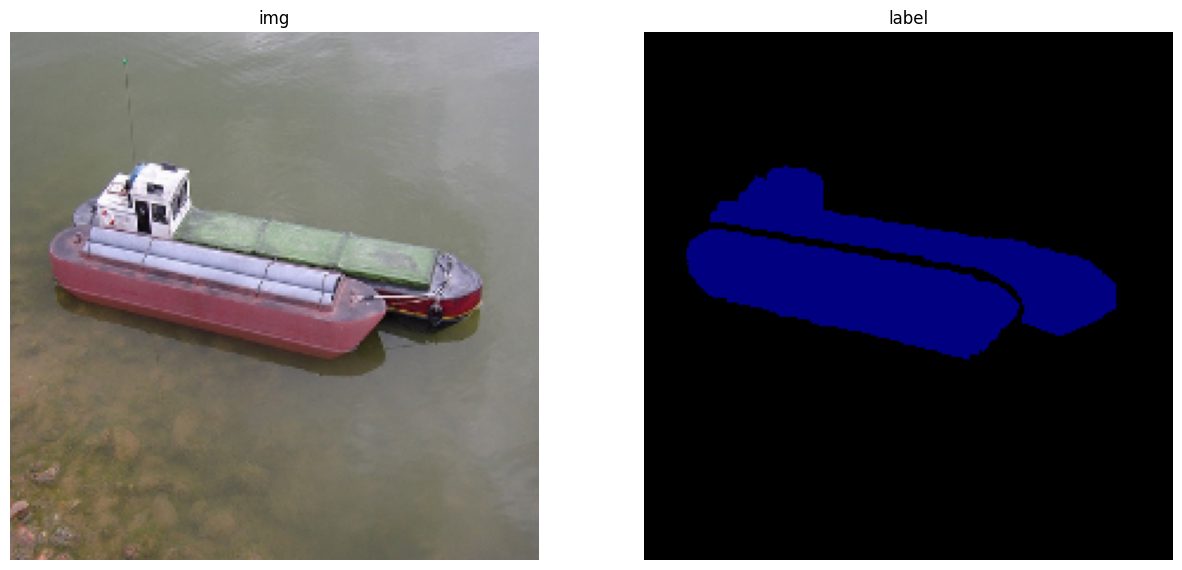

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# train

In [10]:
model = ParseNet(NUM_CLASS + 1, frozen_backbone=True).to(DEVICE)

In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
ParseNet                                      --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

In [12]:
EPOCHES = 30

In [13]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [14]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 91/91 [00:31<00:00,  2.89it/s]


epoch 1 : 0.07137057705076186


100%|██████████| 91/91 [00:31<00:00,  2.91it/s]


epoch 2 : 0.034027734464341465


100%|██████████| 91/91 [00:28<00:00,  3.15it/s]


epoch 3 : 0.027435858416688313


100%|██████████| 91/91 [00:29<00:00,  3.06it/s]


epoch 4 : 0.02346152975991532


100%|██████████| 91/91 [00:31<00:00,  2.93it/s]


epoch 5 : 0.020588911895814178


100%|██████████| 91/91 [00:30<00:00,  2.95it/s]


epoch 6 : 0.018501854921271512


100%|██████████| 91/91 [00:30<00:00,  2.99it/s]


epoch 7 : 0.01643908622541598


100%|██████████| 91/91 [00:28<00:00,  3.20it/s]


epoch 8 : 0.014799488933531793


100%|██████████| 91/91 [00:28<00:00,  3.18it/s]


epoch 9 : 0.013406190826752028


100%|██████████| 91/91 [00:28<00:00,  3.21it/s]


epoch 10 : 0.012389801094656462


100%|██████████| 91/91 [00:29<00:00,  3.12it/s]


epoch 11 : 0.01130948442413093


100%|██████████| 91/91 [00:28<00:00,  3.18it/s]


epoch 12 : 0.010455632884219124


100%|██████████| 91/91 [00:29<00:00,  3.12it/s]


epoch 13 : 0.00985194515477825


100%|██████████| 91/91 [00:28<00:00,  3.15it/s]


epoch 14 : 0.009301583062611765


100%|██████████| 91/91 [00:28<00:00,  3.22it/s]


epoch 15 : 0.008686345950751514


100%|██████████| 91/91 [00:27<00:00,  3.28it/s]


epoch 16 : 0.008259927720895835


100%|██████████| 91/91 [00:29<00:00,  3.12it/s]


epoch 17 : 0.007966994077663173


100%|██████████| 91/91 [00:28<00:00,  3.14it/s]


epoch 18 : 0.0076611901039851235


100%|██████████| 91/91 [00:29<00:00,  3.12it/s]


epoch 19 : 0.007350170795529426


100%|██████████| 91/91 [00:28<00:00,  3.16it/s]


epoch 20 : 0.007179595284409575


100%|██████████| 91/91 [00:28<00:00,  3.20it/s]


epoch 21 : 0.006828994346925845


100%|██████████| 91/91 [00:28<00:00,  3.22it/s]


epoch 22 : 0.006670725096917742


100%|██████████| 91/91 [00:28<00:00,  3.22it/s]


epoch 23 : 0.006410498857743792


100%|██████████| 91/91 [00:28<00:00,  3.19it/s]


epoch 24 : 0.006220874673390126


100%|██████████| 91/91 [00:28<00:00,  3.24it/s]


epoch 25 : 0.006113387321910033


100%|██████████| 91/91 [00:28<00:00,  3.22it/s]


epoch 26 : 0.005978882179728576


100%|██████████| 91/91 [00:28<00:00,  3.23it/s]


epoch 27 : 0.0059173273505990975


100%|██████████| 91/91 [00:28<00:00,  3.16it/s]


epoch 28 : 0.005758987662924843


100%|██████████| 91/91 [00:28<00:00,  3.20it/s]


epoch 29 : 0.0055980404664936305


100%|██████████| 91/91 [00:29<00:00,  3.12it/s]

epoch 30 : 0.005523568280245904


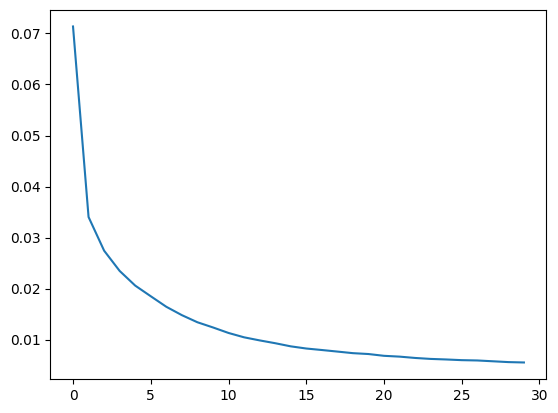

In [17]:
plt.plot(training_loss)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
ParseNet                                      --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

In [19]:
model_path = artifacts_path.joinpath('parsent.pth')

In [20]:
torch.save(model.state_dict(), model_path)

In [21]:
get_file_size(model_path)

'78.35MiB'

# inference

In [22]:
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

### dice coef

In [23]:
from torchmetrics.classification import jaccard

In [24]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


In [25]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.72 
bicycle        : 0.37 
bird           : 0.83 
boat           : 0.71 
bottle         : 0.7  
bus            : 0.86 
car            : 0.79 
cat            : 0.85 
chair          : 0.49 
cow            : 0.75 
diningtable    : 0.69 
dog            : 0.75 
horse          : 0.66 
motorbike      : 0.72 
person         : 0.76 
pottedplant    : 0.43 
sheep          : 0.78 
sofa           : 0.67 
train          : 0.86 
tvmonitor      : 0.7  
----------------------
total          : 0.7  


### for image in dataset

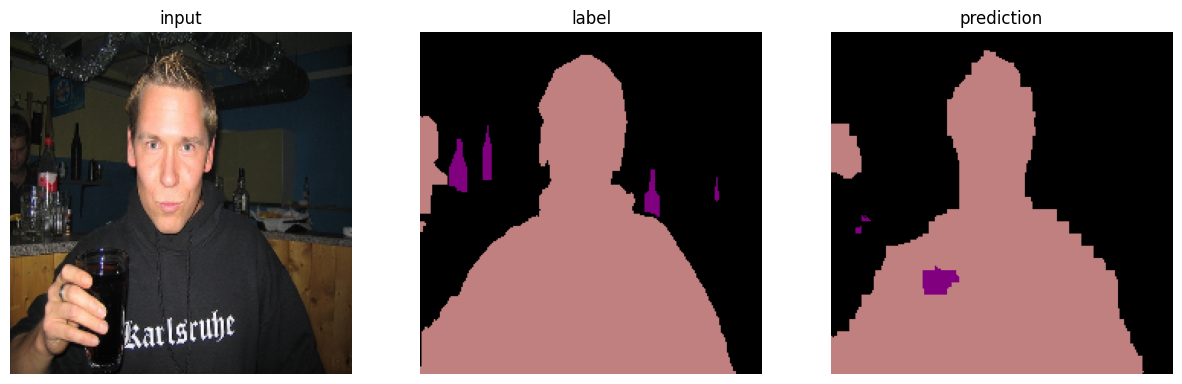

In [26]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

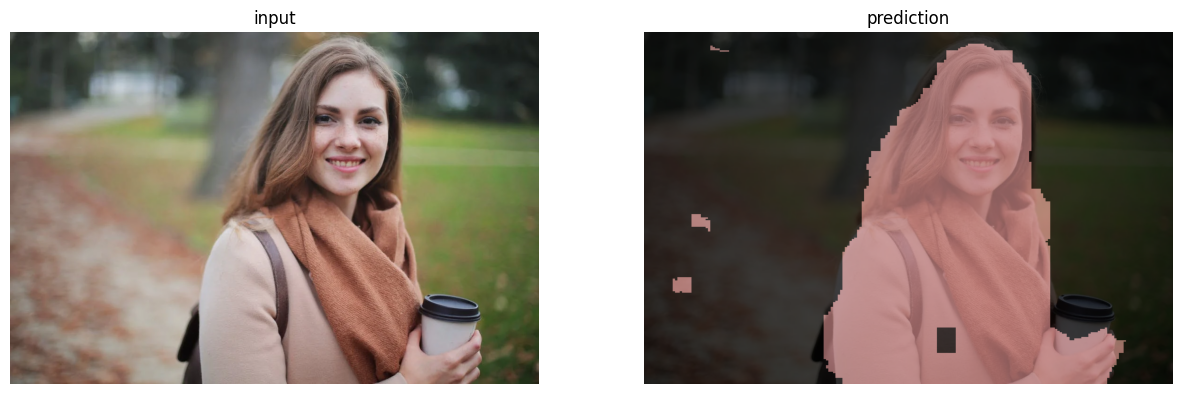

In [27]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )